# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://richmond.craigslist.org/search/mca?purveyor=owner#search=1~gallery~0~57'
raw = requests.get(url,headers=header) # Get page

### I am looking at motorcycles on Richmond Craigslist. I want to gather data about the year of the motorcycle, the brand of the motorcycle, and the price of the motorcycle. I would do EDA on it by looking at which brands are most often being sold, what price motorcycles are typically sold at, and how old the motorcycles being sold typically are. I also want to look at the relationship between brand and price as well as age of motorcycle and price.

---



Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [9]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [10]:
import re # Regular expressions

brands = ['harley', 'yamaha', 'ducati', 'vespa', 'honda', 'bmw', 'suzuki', 'ridley', 'dyna', 'stella', 'kawasaki', 'klr',
          'triumph', 'can-am', 'victory', 'ktm']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

### I used code to extract the year and brand of each motorcycle.

---

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [11]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_richmond_motorcycles.csv') # Save data in case of a disaster
df.head()

(65, 6)


,title,price,year,link,brand,age
0,2005 kawasaki ninja zx6r zx 636 sport bike,5000,2005.0,https://richmond.craigslist.org/mcy/d/beaverda...,kawasaki,20.0
1,2007 honda cbr600rr,3500,2007.0,https://richmond.craigslist.org/mcy/d/richmond...,honda,18.0
2,1999 harley davidson softail,5300,1999.0,https://richmond.craigslist.org/mcy/d/glen-all...,harley,26.0
3,2013 road king,14000,2013.0,https://richmond.craigslist.org/mcy/d/richmond...,missing,12.0
4,2017 gsx-r600,8200,2017.0,https://richmond.craigslist.org/mcy/d/henrico-...,missing,8.0


With the data in and wrangled, we can now do EDA:

count       53.000000
mean      7249.981132
std       4001.448058
min        800.000000
25%       4400.000000
50%       6500.000000
75%       9500.000000
max      17500.000000
Name: price, dtype: float64


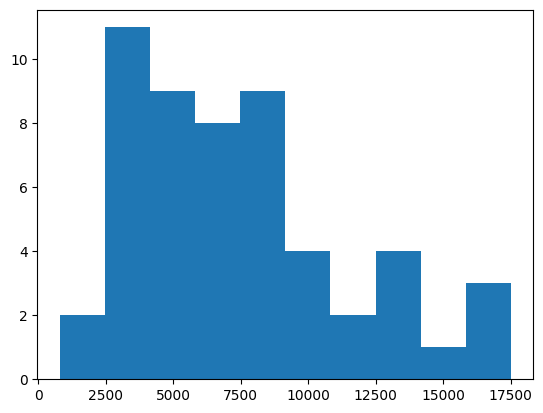

In [19]:
# EDA for price: histogram of frequency by motorcycle price
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

Most of the motorcycles are priced around \$2500 - $8750, with some prices lying outside of this range.

count    53.000000
mean     16.509434
std      13.159703
min       1.000000
25%       6.000000
50%      16.000000
75%      21.000000
max      52.000000
Name: age, dtype: float64


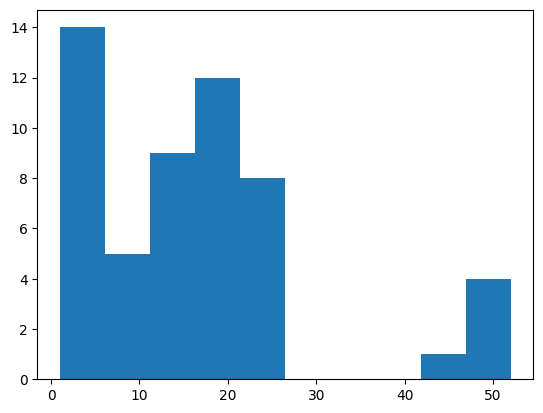

In [20]:
# EDA for age: histogram of frequency by motorcycle age
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

A lot of the listings are for relatively newer motorcycles, up to 5 years old, or for somewhat older motorcycles, in the range of 10 to 25 years old.

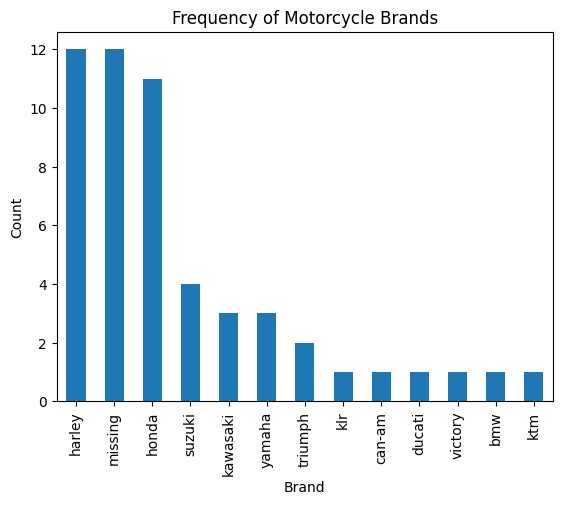

,count
brand,
harley,12
missing,12
honda,11
suzuki,4
kawasaki,3
yamaha,3
triumph,2
klr,1
can-am,1


In [22]:
# bar plot of brands
brand_counts = df['brand'].value_counts()

brand_counts.plot(kind='bar')

plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Frequency of Motorcycle Brands')

plt.show()

brand_counts

The most common motorcycle brands listed are Harley and Honda which makes sense because these are well known motorcycle companies. There are some other listings for various other brands but they are less common.

In [25]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                                 \
         count          mean          std      min      25%      50%      75%   
brand                                                                           
bmw        1.0   7500.000000          NaN   7500.0   7500.0   7500.0   7500.0   
can-am     1.0  13000.000000          NaN  13000.0  13000.0  13000.0  13000.0   
ducati     1.0   4500.000000          NaN   4500.0   4500.0   4500.0   4500.0   
harley    12.0   9066.583333  3865.615333   3000.0   6500.0   8500.0  11000.0   
honda     11.0   4100.000000  2113.764414    800.0   3350.0   3500.0   5000.0   
kawasaki   3.0   5416.666667  3145.764348   2500.0   3750.0   5000.0   6875.0   
klr        1.0   6500.000000          NaN   6500.0   6500.0   6500.0   6500.0   
ktm        1.0  12500.000000          NaN  12500.0  12500.0  12500.0  12500.0   
missing   12.0   8416.666667  4120.863399   3000.0   5875.0   7600.0  10625.0   
suzuki     4.0   7800.000000  6799.019537   2700.0   3300.0   5500.0  10000.0   
triumph    2.0   8050.000000  2616.295090   6200.0   7125.0   8050.0   8975.0   
victory    1.0   7900.000000          NaN   7900.0   7900.0   7900.0   7900.0   
yamaha     3.0   4633.333333  1415.391583   3000.0   4200.0   5400.0   5450.0   

                   
              max  
brand              
bmw        7500.0  
can-am    13000.0  
ducati     4500.0  
harley    15999.0  
honda      8300.0  
kawasaki   8750.0  
klr        6500.0  
ktm       12500.0  
missing   16000.0  
suzuki    17500.0  
triumph    9900.0  
victory    7900.0  
yamaha     5500.0

It is interesting to view the difference in price between various brands. Of the most common brands, Harley and Honda, Harley seems to be more premium with a greater mean price around \$9000 while the mean price for a Honda is less than half at around \$4000. It is interesting to see that the cheapest motorcycle being sold was a Honda at \$800 while the most expensive was a Suzuki at \$17500.

In [26]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
         count       mean        std   min    25%   50%    75%   max
brand                                                               
bmw        1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
can-am     1.0   5.000000        NaN   5.0   5.00   5.0   5.00   5.0
ducati     1.0  24.000000        NaN  24.0  24.00  24.0  24.00  24.0
harley    12.0  16.000000   6.941312   3.0  11.00  17.0  21.25  26.0
honda     11.0  18.909091  16.281613   3.0   4.00  18.0  22.00  52.0
kawasaki   3.0  11.666667   9.712535   1.0   7.50  14.0  17.00  20.0
klr        1.0   2.000000        NaN   2.0   2.00   2.0   2.00   2.0
ktm        1.0   5.000000        NaN   5.0   5.00   5.0   5.00   5.0
missing   12.0  16.166667  13.099850   1.0   8.75  12.0  20.25  52.0
suzuki     4.0  23.000000  20.281354   3.0  12.75  19.0  29.25  51.0
triumph    2.0   2.500000   0.707107   2.0   2.25   2.5   2.75   3.0
victory    1.0  20.000000        NaN  20.0  20.00  20.0  20.00  20.0
yamaha     3.0  28.333333  19.731531  15.0  17.00  19.0  35.00  51.0

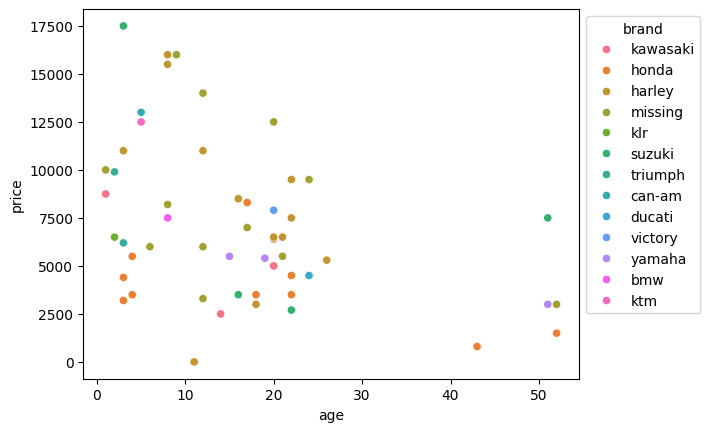

In [15]:
# relationship between price and age, colored by brand
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   0.521615 -0.250155
log_age    -0.250155  0.942285
           log_price  log_age
log_price    1.00000 -0.41212
log_age     -0.41212  1.00000


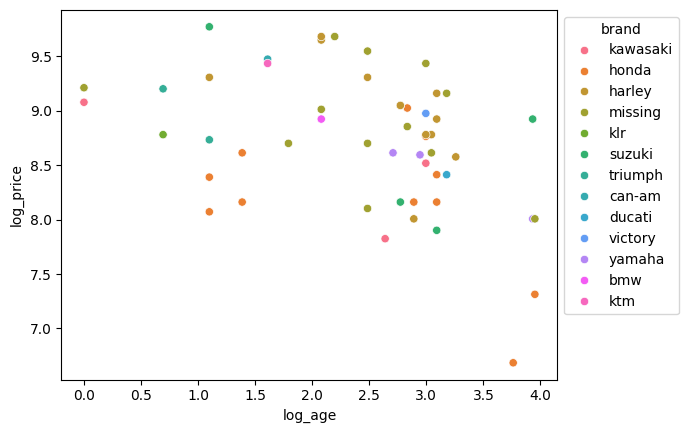

In [16]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

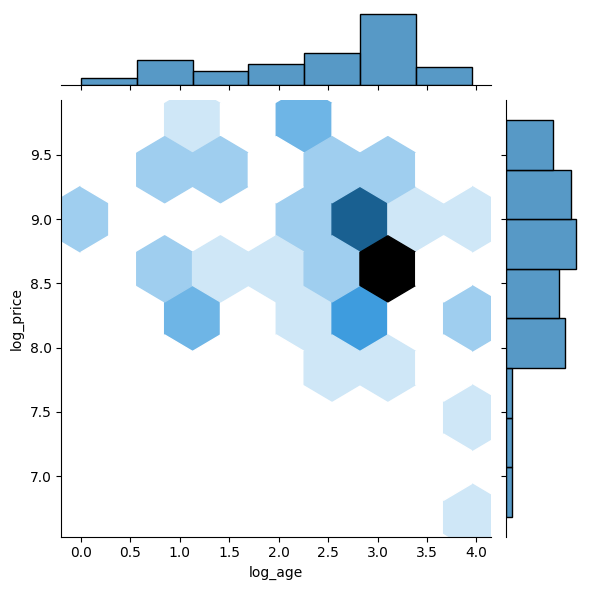

In [18]:
# Replacing infinite with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
df.dropna(inplace=True)

sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')